# Display Model Performance

In [76]:
import argparse
from pathlib import Path

import numpy as np
import torch
import matplotlib.pyplot as plt

In [77]:

from models.mini_mae_v2 import ECGMAE_1D, mae_loss_masked
from data.dataset import SingleNpyECGDataset

In [78]:
npy_path = './data/mitdb_singlelead_500hz_10s.npy'

ds = SingleNpyECGDataset(npy_path, limit=1)
print(f"Dataset length: {len(ds)}")


Dataset length: 1


torch.Size([1, 5000])


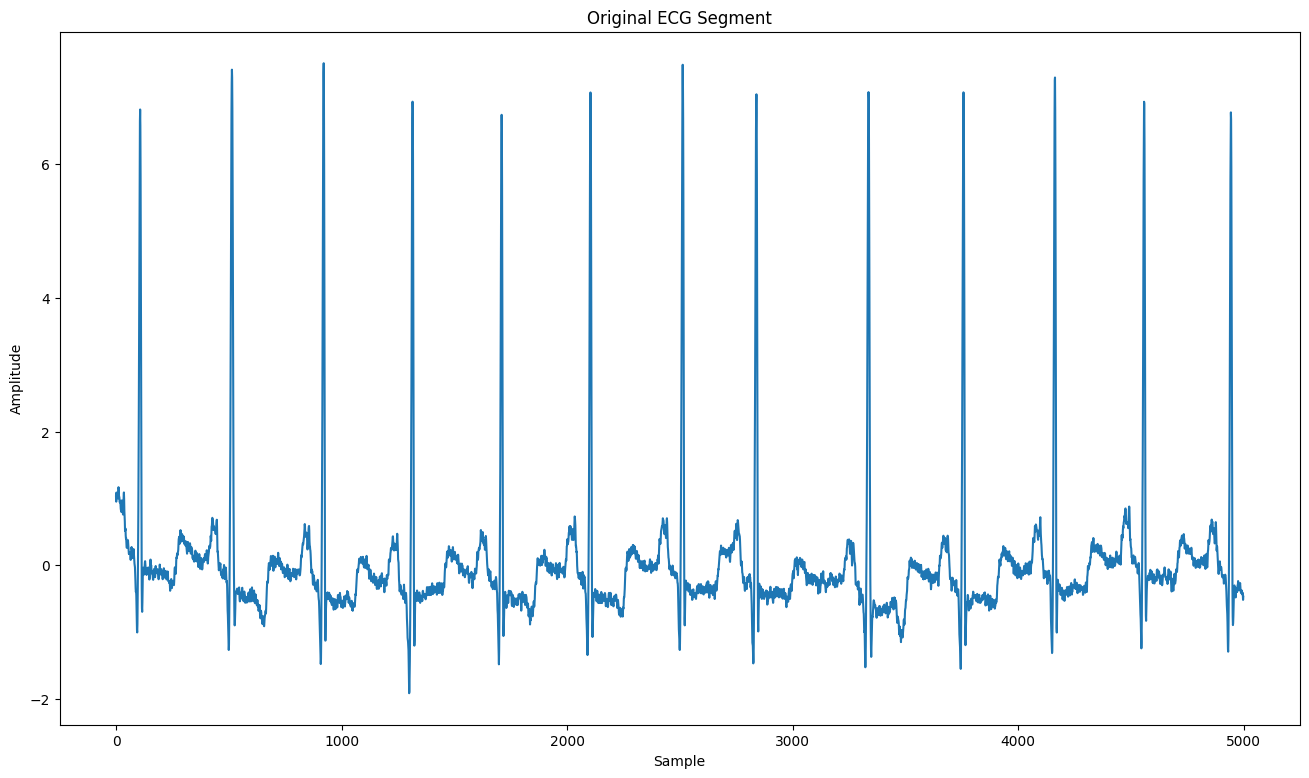

In [79]:
# Example ECG Segment
x = ds[0]

print(x.shape)

plt.figure(figsize=(16, 9))
plt.plot(x[0])
plt.xlabel(f'Sample')
plt.ylabel(f'Amplitude')
plt.title(f'Original ECG Segment')
plt.show()

In [80]:
def unpatchify_1lead(patches: torch.Tensor, patch_size: int) -> torch.Tensor:
    """
    patches: [T, P]  (1 lead -> N*P == P)
    return:  [L] where L = T*P
    """
    # [T, P] -> [T*P]
    return patches.reshape(-1)

In [81]:
@torch.no_grad()
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--ckpt", type=str, required=True, help="Path to checkpoint .pt/.pth")
    parser.add_argument("--npy", type=str, required=True, help="Path to training npy, shape [N, L] or [N, 1, L]")
    parser.add_argument("--index", type=int, default=0, help="Which sample index to visualize")
    parser.add_argument("--device", type=str, default="cuda", choices=["cpu", "cuda"])
    # must match training config
    parser.add_argument("--n_leads", type=int, default=1)
    parser.add_argument("--patch_size", type=int, default=10)
    parser.add_argument("--d_model", type=int, default=128)
    parser.add_argument("--depth", type=int, default=4)
    parser.add_argument("--n_heads", type=int, default=4)
    parser.add_argument("--dim_ff", type=int, default=256)
    parser.add_argument("--dropout", type=float, default=0.1)
    parser.add_argument("--mask_ratio", type=float, default=0.6)
    parser.add_argument("--pos_max_len", type=int, default=2048)

    args = parser.parse_args()

    device = torch.device("cuda" if (args.device == "cuda" and torch.cuda.is_available()) else "cpu")

    # 1) Build model with SAME hyperparams as training
    model = ECGMAE_1D(
        n_leads=args.n_leads,
        d_model=args.d_model,
        patch_size=args.patch_size,
        # depth=args.depth,
        enc_depth=4,
        dec_depth=2,
        n_heads=args.n_heads,
        dim_ff=args.dim_ff,
        dropout=args.dropout,
        mask_ratio=args.mask_ratio,
        pos_max_len=args.pos_max_len,
    ).to(device)

    # 2) Load checkpoint
    ckpt = torch.load(args.ckpt, map_location="cpu")

    # common patterns:
    # - torch.save(model.state_dict(), path)
    # - torch.save({"model": model.state_dict(), ...}, path)
    if isinstance(ckpt, dict) and "model" in ckpt:
        state = ckpt["model"]
    elif isinstance(ckpt, dict) and "state_dict" in ckpt:
        state = ckpt["state_dict"]
    else:
        state = ckpt

    # If keys are like "module.xxx" from DDP, strip "module."
    new_state = {}
    for k, v in state.items():
        if k.startswith("module."):
            new_state[k[len("module."):]] = v
        else:
            new_state[k] = v

    missing, unexpected = model.load_state_dict(new_state, strict=False)
    print("Loaded ckpt:", args.ckpt)
    print("Missing keys:", missing)
    print("Unexpected keys:", unexpected)

    model.eval()

    # 3) Load one sample from npy
    arr = np.load(args.npy)  # [N, L] or [N, 1, L]
    x = arr[args.index]

    if x.ndim == 1:
        # [L] -> [1, 1, L]
        x = x[None, None, :]
    elif x.ndim == 2:
        # could be [1, L] -> [1, 1, L] OR [N_leads, L]
        x = x[None, :, :]
    else:
        raise ValueError(f"Unsupported sample shape: {x.shape}")

    x = torch.tensor(x, dtype=torch.float32, device=device)  # [B=1, N, L]
    B, N, L = x.shape
    assert N == args.n_leads, f"n_leads mismatch: sample has {N}, args has {args.n_leads}"
    assert L % args.patch_size == 0, f"L={L} must be divisible by patch_size={args.patch_size}"

    # 4) Forward
    pred_patches, tgt_patches, mask = model(x)
    # shapes:
    # pred/tgt: [1, T, N*P], mask: [1, T] True=masked

    # take first (only) sample, and 1-lead case means last dim == patch_size
    pred = pred_patches[0].detach().cpu()  # [T, P]
    tgt = tgt_patches[0].detach().cpu()    # [T, P]
    m = mask[0].detach().cpu()             # [T] bool

    if m.dtype != torch.bool:
        m = m > 0.5

    # 5) Build masked input (visible only)
    # For visualization: keep visible patches, masked ones set to NaN so the line breaks
    masked = tgt.clone()
    masked[m] = float("nan")

    # 6) Build reconstructed signal (use tgt for visible patches, pred for masked patches)
    recon = tgt.clone()
    recon[m] = pred[m]

    # 7) Unpatchify to 1D waveforms
    y_true = unpatchify_1lead(tgt, args.patch_size).numpy()
    y_masked = unpatchify_1lead(masked, args.patch_size).numpy()
    y_recon = unpatchify_1lead(recon, args.patch_size).numpy()

    # # 8) Plot
    # plt.figure(figsize=(14, 4))
    # plt.plot(y_true, label="Original")
    # plt.plot(y_masked + 1, label="Masked (visible only)")
    # plt.plot(y_recon + 2, label="Reconstructed (pred fills masked)")
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

    return y_true, y_masked, y_recon

Loaded ckpt: ./outputs/runs/2025-12-13_2008_mae_mitdb/checkpoints/best.pt
Missing keys: ['patch_embed.proj.weight', 'patch_embed.proj.bias', 'pos_embed_enc.pe', 'encoder.0.ln1.weight', 'encoder.0.ln1.bias', 'encoder.0.attn.in_proj_weight', 'encoder.0.attn.in_proj_bias', 'encoder.0.attn.out_proj.weight', 'encoder.0.attn.out_proj.bias', 'encoder.0.ln2.weight', 'encoder.0.ln2.bias', 'encoder.0.mlp.fc1.weight', 'encoder.0.mlp.fc1.bias', 'encoder.0.mlp.fc2.weight', 'encoder.0.mlp.fc2.bias', 'encoder.1.ln1.weight', 'encoder.1.ln1.bias', 'encoder.1.attn.in_proj_weight', 'encoder.1.attn.in_proj_bias', 'encoder.1.attn.out_proj.weight', 'encoder.1.attn.out_proj.bias', 'encoder.1.ln2.weight', 'encoder.1.ln2.bias', 'encoder.1.mlp.fc1.weight', 'encoder.1.mlp.fc1.bias', 'encoder.1.mlp.fc2.weight', 'encoder.1.mlp.fc2.bias', 'encoder.2.ln1.weight', 'encoder.2.ln1.bias', 'encoder.2.attn.in_proj_weight', 'encoder.2.attn.in_proj_bias', 'encoder.2.attn.out_proj.weight', 'encoder.2.attn.out_proj.bias', 'en

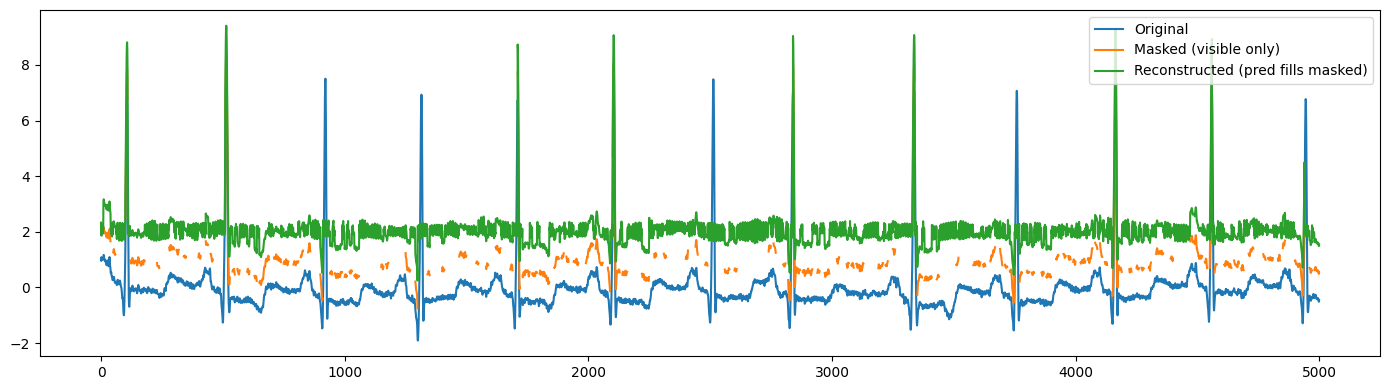

In [82]:
import sys

sys.argv = [
    "notebook",
    # "--ckpt", "./outputs/runs/2025-12-14_0206_mae_mitdb/checkpoints/best.pt",
    "--ckpt", "./outputs/runs/2025-12-13_2008_mae_mitdb/checkpoints/best.pt",
    "--npy", "./data/mitdb_singlelead_500hz_10s.npy",
    "--index", "0",
    "--device", "cuda",
    "--n_leads", "1",
    "--patch_size", "10",
    "--d_model", "128",
    "--n_heads", "4",
    "--dim_ff", "256",
    "--dropout", "0.1",
    "--mask_ratio", "0.6",
    "--pos_max_len", "4096",
]

y_true, y_masked, y_recon = main()

plt.figure(figsize=(14, 4))
plt.plot(y_true, label="Original")
plt.plot(y_masked + 1, label="Masked (visible only)")
plt.plot(y_recon + 2, label="Reconstructed (pred fills masked)")
plt.legend()
plt.tight_layout()
plt.show()


Loaded ckpt: ./outputs/runs/2025-12-14_0206_mae_mitdb/checkpoints/best.pt
Missing keys: []
Unexpected keys: []


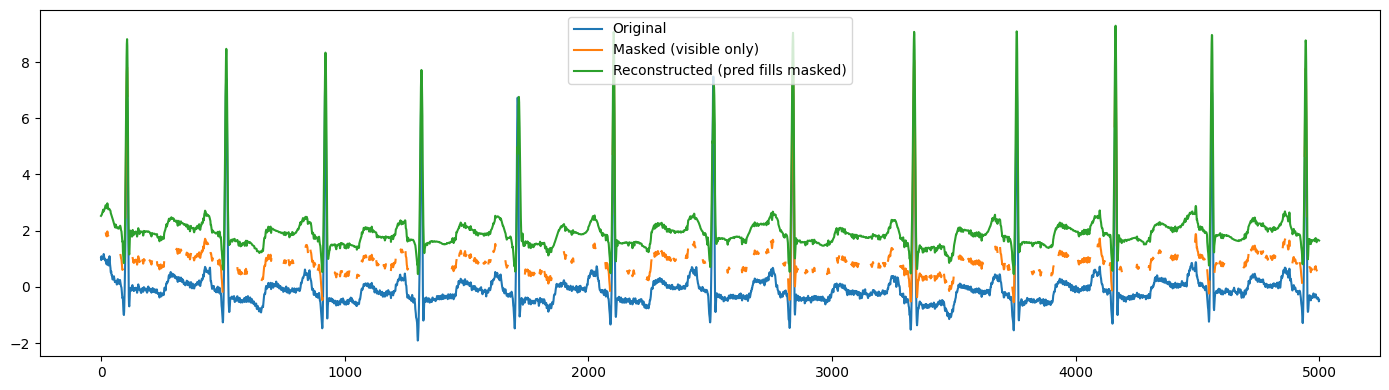

In [83]:
import sys

sys.argv = [
    "notebook",
    "--ckpt", "./outputs/runs/2025-12-14_0206_mae_mitdb/checkpoints/best.pt",
    # "--ckpt", "./outputs/runs/2025-12-13_2008_mae_mitdb/checkpoints/best.pt",
    "--npy", "./data/mitdb_singlelead_500hz_10s.npy",
    "--index", "0",
    "--device", "cuda",
    "--n_leads", "1",
    "--patch_size", "10",
    "--d_model", "128",
    "--n_heads", "4",
    "--dim_ff", "256",
    "--dropout", "0.1",
    "--mask_ratio", "0.6",
    "--pos_max_len", "4096",
]

y_true, y_masked, y_recon = main()

plt.figure(figsize=(14, 4))
plt.plot(y_true, label="Original")
plt.plot(y_masked + 1, label="Masked (visible only)")
plt.plot(y_recon + 2, label="Reconstructed (pred fills masked)")
plt.legend()
plt.tight_layout()
plt.show()

In [99]:
def display_detail(y_true, y_masked, y_recon, left = 0, right = 1000):

    print(sum((y_true - y_recon)**2))

    plt.figure(figsize=(14, 4))
    plt.plot(y_true[left:right], label="Original")
    plt.plot(y_masked[left:right] + 1, label="Masked (visible only)")
    plt.plot(y_recon[left:right] + 2, label="Reconstructed (pred fills masked)")
    plt.legend()
    plt.tight_layout()
    plt.show()

379.639


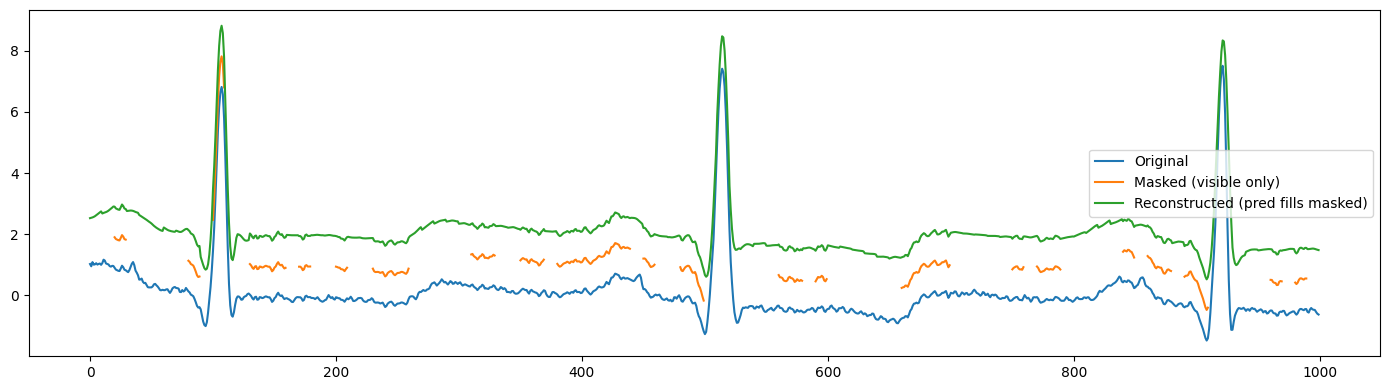

In [100]:
display_detail(y_true, y_masked, y_recon, 0, 1000)

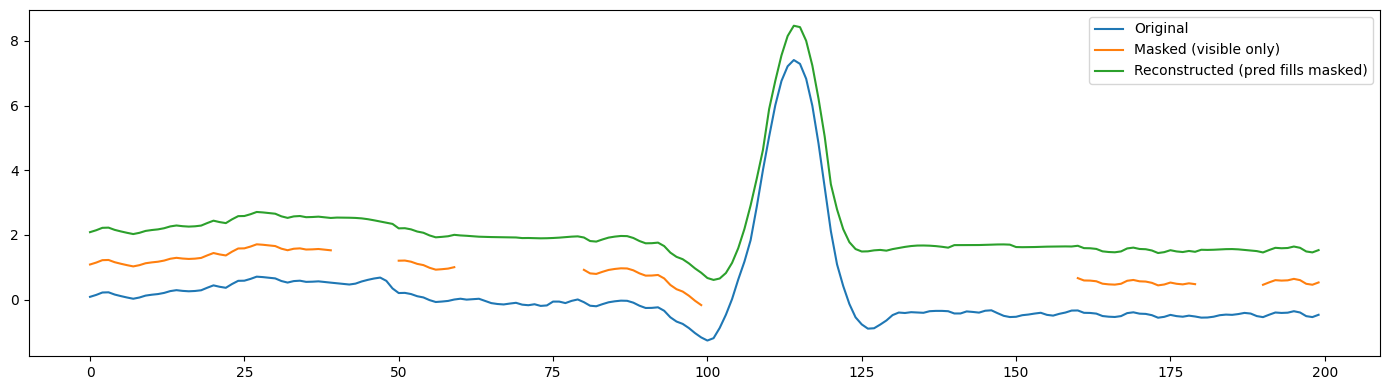

In [90]:
display_detail(y_true, y_masked, y_recon, 400, 600)